In [1]:
from pathlib import Path
from shapely.geometry import LineString
import numpy as np
import ipywidgets as ipyw
import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_files
from pydicom.filereader import read_dicomdir

In [40]:
class ImageSliceViewer3D:
    """ 
    ImageSliceViewer3D is for viewing volumetric image slices in jupyter or
    ipython notebooks. 
    
    User can interactively change the slice plane selection for the image and 
    the slice plane being viewed. 

    Argumentss:
    Volume = 3D input image
    figsize = default(8,8), to set the size of the figure
    cmap = default('gray'), string for the matplotlib colormap. You can find 
    more matplotlib colormaps on the following link:
    https://matplotlib.org/users/colormaps.html
    
    """
    
    def __init__(self, 
                 volume,
                 slicelocations,
                 figsize=(100,100), 
                 cmap='gray', 
                 v=None, 
                 aspect=None
    ):
        self.volume = volume
        self.slicelocations = slicelocations
        self.figsize = figsize
        self.cmap = cmap
        if v is None:
            self.v = [np.min(volume), np.max(volume)]
        else:
            self.v = v
        
        if aspect is None:
            self.aspect = 1
        else:
            self.aspect = aspect
        
        # Call to select slice plane
        ipyw.interact(self.views)
    
    def views(self):
        self.vol1 = np.transpose(self.volume, [1,2,0])
        self.vol2 = np.rot90(np.transpose(self.volume, [2,0,1]), 3) #rotate 270 degrees
        self.vol3 = np.transpose(self.volume, [0,1,2])
        maxZ1 = self.vol1.shape[2] - 1
        maxZ2 = self.vol2.shape[2] - 1
        maxZ3 = self.vol3.shape[2] - 1
        ipyw.interact(self.plot_slice, 
            z1=ipyw.IntSlider(value = maxZ1//2, min=0, max=maxZ1, step=1, continuous_update=False, 
            description='Axial:'), 
            z2=ipyw.IntSlider(value = maxZ2//2, min=0, max=maxZ2, step=1, continuous_update=False, 
            description='Coronal:'),
            z3=ipyw.IntSlider(value = maxZ3//2, min=0, max=maxZ3, step=1, continuous_update=False, 
            description='Sagittal:'))

    def plot_slice(self, z1, z2, z3):
        # Plot slice for the given plane and slice
        f,ax = plt.subplots(1,3, figsize=self.figsize)
        #print(self.figsize)
        #self.fig = plt.figure(figsize=self.figsize)
        #f(figsize = self.figsize)
        ax[0].imshow(self.vol1[:,:,z1], cmap=plt.get_cmap(self.cmap), 
            vmin=self.v[0], vmax=self.v[1], aspect = 1)
        ax[1].imshow(self.vol2[:,:,z2], cmap=plt.get_cmap(self.cmap), 
            vmin=self.v[0], vmax=self.v[1], aspect = self.aspect)
        ax[2].imshow(self.vol3[:,:,z3], cmap=plt.get_cmap(self.cmap), 
            vmin=self.v[0], vmax=self.v[1], aspect = self.aspect)
        plt.show()
        

In [41]:
directory = 'DICOM Data/CT'
list_of_files = [ file for file in Path(directory).iterdir() if file.suffix == ".dcm" ]
filtered_list = filter(lambda x: pydicom.dcmread(x).Modality == "CT", list_of_files)
sorted_list = sorted(filtered_list, key=lambda x: pydicom.dcmread(x,force=True).InstanceNumber)

print('Path to the DICOM directory: {}'.format(directory))

#get the pixel array
datasets = [pydicom.dcmread(image_filename).pixel_array
                        for image_filename in sorted_list]
slicelocations = np.array([pydicom.dcmread(image_filename).SliceLocation
                        for image_filename in sorted_list])

#convert to numpy array
ds = pydicom.dcmread(sorted_list[0])
aspect = ds.SliceThickness / ds.PixelSpacing[0]
npa = np.array(datasets)
ImageSliceViewer3D(volume=npa, 
                   slicelocations=slicelocations ,
                   v=[500,1500], 
                   aspect=aspect)

Path to the DICOM directory: DICOM Data/CT


interactive(children=(Output(),), _dom_classes=('widget-interact',))

PTV_p
8
Bladder
2
Rectum
9
Femur_Head_L
5
Femur_Head_R
6
Ring_HD
26
ExternalClean
14


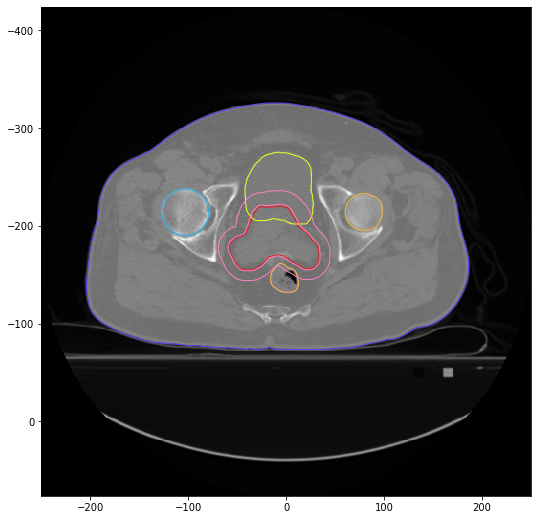

In [4]:
slice_num = 110

# CT Dataset
directory = 'DICOM Data/CT'
list_of_files = [ file for file in Path(directory).iterdir() if file.suffix == ".dcm" ]
filtered_list = filter(lambda x: pydicom.dcmread(x).Modality == "CT", list_of_files)
sorted_list = sorted(filtered_list, key=lambda x: pydicom.dcmread(x,force=True).InstanceNumber)
slicelocations = np.array([pydicom.dcmread(image_filename).SliceLocation
                        for image_filename in sorted_list])
z = slicelocations[slice_num]

# Structure Set
ss = Path('DICOM Data/RS1.2.752.243.1.1.20220223090558739.4000.72166.dcm')
dss = pydicom.dcmread(ss)

roi_list = ["PTV_p", "Bladder", "Rectum", "Femur_Head_L", "Femur_Head_R","Ring_HD", "ExternalClean"]

fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Plot CT slice
for file in sorted_list:
    ds = pydicom.dcmread(file)
    if ds.SliceLocation == z:
        pixel_data = ds.pixel_array

extent = [
    ds.ImagePositionPatient[0] - ds.PixelSpacing[0]/2,
    ds.ImagePositionPatient[0] + (ds.Columns-1)*ds.PixelSpacing[0] + ds.PixelSpacing[0]/2,
    ds.ImagePositionPatient[1] + (ds.Rows-1)*ds.PixelSpacing[1] + ds.PixelSpacing[1]/2,
    ds.ImagePositionPatient[1] - ds.PixelSpacing[1]/2,
]

ax.imshow(pixel_data, extent=extent,cmap="gray")

roi_dict = {}

# Plot Structures
for roi_label in roi_list:
    
    roi_dict[roi_label] = []
    # Find the ROI number
    
    roi_number = None
    for dcm_roi in dss.StructureSetROISequence:
        if dcm_roi.ROIName == roi_label:
            roi_number = dcm_roi.ROINumber
     
    print(roi_label)
    print(roi_number)
    
    
    assert roi_number is not None, f"Could not find {roi}"
    
    # Get the ROI Contours
    roi = None
    for roi_contour_item in dss.ROIContourSequence:
        if roi_contour_item.ReferencedROINumber == roi_number:
            roi = roi_contour_item
    
    roi_color = roi.ROIDisplayColor
    roi_contour_stack = roi.ContourSequence
    
    for contour in roi_contour_stack:
        list_of_points = np.reshape(contour.ContourData, (contour.NumberOfContourPoints,3))
        if list_of_points[0,2] == z:
            roi_dict[roi_label].append(list_of_points)
            x=list_of_points[:,0]
            y=list_of_points[:,1]
            ax.fill(x, y, facecolor='none', edgecolor=np.array(roi_color)/256)
        

In [5]:
print(ds.ImagePositionPatient)
print(ds.Columns)
print(ds.Rows)
print(ds.PixelSpacing)

[-249.51171875, -423.51171875, -841.8]
512
512
[0.9765625, 0.9765625]


In [6]:
# Plan
plan = Path('DICOM Data/RP1.2.752.243.1.1.20220223092421606.1900.15058.dcm')
dsp = pydicom.dcmread(plan)
for beam in dsp.BeamSequence:
    cp1 = beam.ControlPointSequence[0]
    print(f"Beam {beam.BeamNumber} has a gantry angle of {cp1.GantryAngle}")
    
print(f"Isocenter is located at {cp1.IsocenterPosition}")

Beam 1 has a gantry angle of 210
Beam 2 has a gantry angle of 260
Beam 3 has a gantry angle of 310
Beam 4 has a gantry angle of 0
Beam 5 has a gantry angle of 50
Beam 6 has a gantry angle of 100
Beam 7 has a gantry angle of 150
Isocenter is located at [-11.32453, -195.2993, -632.4196]


# Analytical model for dose calculation
The equation from AAPM TG-71 for monitor unit calculation of beams for the SAD technique is:
$$ 
MU = \frac{D}{\dot{D}_0 \times S_c(r_c) \times S_p(r_d) \times \mathrm{TPR}(d,r_d) \times \mathrm{WF}(d,r_d,x) \times \mathrm{TF} \times \mathrm{OAR}(d,x) \times \left(\frac{\mathrm{SSD}_0 + d_0}{\mathrm{SPD}}\right)^2 }
$$

We make the following simplifying assumptions:
* $\dot{D}_0$ is 1 cGy/MU under reference conditions:
    * 10x10 field
    * $\mathrm{SSD}_0$ = 100 cm SSD
    * $d_0$ = depth of maximum dose = 2.3 cm (10 MV photons)
* $S_c(r_c) = 1$ and $S_p(r_d) = 1$ (ignore field size)
* $\mathrm{TPR}(d,r_d)$ is the tabulated TMR for a 10 MV photon beam, 6x6 cm field, found at in Khan The Physics of Treatment Planning (4th ed., page A-19)
* $\mathrm{WF}(d,r_d,x) = 1$ No wedges
* $\mathrm{TF}= 1$ No tray
* $\mathrm{OAR}(d,x) = 1$ Our beam profiles are perfectly flat

The equation simplifies to:
$$ 
MU = \frac{D}{\mathrm{TPR}(d) \times \left(\frac{102.3 cm}{\mathrm{SPD}}\right)^2 }
$$

Solving for dose:
$$ 
D = MU \times \mathrm{TPR}(d) \times \left(\frac{102.3 cm}{\mathrm{SPD}}\right)^2
$$

Where:
* $d$ is the depth of the point in the patient, and:
* SPD is the source to point distance

The tabulated TPR is in the cell below

In [7]:
TMR_10MV_6x6 = np.array(
    [
        [0,0.081],
        [0.2,0.411],
        [0.5,0.663],
        [1,0.864],
        [1.5,0.941],
        [2,0.97],
        [2.5,1],
        [3,1],
        [4,0.992],
        [5,0.963],
        [6,0.934],
        [7,0.906],
        [8,0.878],
        [9,0.851],
        [10,0.824],
        [11,0.798],
        [12,0.773],
        [13,0.749],
        [14,0.725],
        [15,0.701],
        [16,0.678],
        [17,0.626],
        [18,0.634],
        [19,0.613],
        [20,0.593],
        [22,0.553],
        [24,0.516],
        [26,0.481],
        [28,0.448],
        [30,0.417],
        [40,0.262], # A linear extrapolation of the last two points      
    ]
)

def TMR(depth):
    """
    Returns the TMR for a 10 MV, 6x6 cm field for the provided depth
    
    ----------
    PARAMETERS
    ----------
    depth: float
        The depth, in cm
        
    -------
    RETURNS
    -------
    The TPR, expressed as a fraction
    
    """
    
    assert depth >= 0, "Depth must be a non-negative number"
    assert depth <= 40, "Depth must be less than 40 cm"
    
    depths = TMR_10MV_6x6[:,0]
    TPRs = TMR_10MV_6x6[:,1]
    
    return np.interp(depth, depths, TPRs) 
    

def SPD(point, isocenter, gantry_angle):
    """
    Returns the source-to-point distance, in cm
    
    ----------
    PARAMETERS
    ----------
    point: list of float
        The x,y,z location of the point of interest, in DICOM coordinates (mm)
    isocenter: list of float
        The x,y,z location of the isocenter, in DICOM coordinates (mm)
    gantry_angle: float
        The gantry angle
        
    -------
    RETURNS
    -------
    The SPD, in cm
    
    -----
    NOTES
    -----
    There are million ways this function could break, 
    mostly due to incorrect calculation of the source location
    
    """
    
    point_x = point[0]
    point_y = point[1]
    
    # Compute the source location
    iso_x = isocenter[0]
    iso_y = isocenter[1]
    
    # In image coordinates
    # 0 degrees is 100 cm more negative in the y direction
    # 180 degrees is 100 cm more positive in the y direction
    # 90 degrees is 100 cm more positive in the x direction
    # 270 degrees is 100 cm more negative in the x direction
    gantry_radians = np.pi*(gantry_angle/180)
    source_x = iso_x + 1000*np.sin(gantry_radians)
    source_y = iso_y - 1000*np.cos(gantry_radians)
    
    return np.sqrt((point_x-source_x)**2 + (point_y-source_y)**2)/10

def get_depth(point, isocenter, gantry_angle, external):
    """
    Returns the depth of the point, in cm
    
    ----------
    PARAMETERS
    ----------
    point: list of float
        The x,y,z location of the point of interest, in DICOM coordinates (mm)
    isocenter: list of float
        The x,y,z location of the isocenter, in DICOM coordinates (mm)
    gantry_angle: float
        The gantry angle
    external: np.array
        The output of roi_dict["ExternalClean"][0], which gives the list of points that define the external contour
        
    -------
    RETURNS
    -------
    The depth, in cm
    
    -----
    NOTES
    -----
    
    
    """
    point_x = point[0]
    point_y = point[1]
    
    # Compute the source location
    iso_x = isocenter[0]
    iso_y = isocenter[1]
    
    # In image coordinates
    # 0 degrees is 100 cm more negative in the y direction
    # 180 degrees is 100 cm more positive in the y direction
    # 90 degrees is 100 cm more positive in the x direction
    # 270 degrees is 100 cm more negative in the x direction
    gantry_radians = np.pi*(gantry_angle/180)
    source_x = iso_x + 1000*np.sin(gantry_radians)
    source_y = iso_y - 1000*np.cos(gantry_radians)
    
    
    # Now you have the source and point location. From here, you need to figure one:
    # 1. What is the intersection between the source-point line, and [Guessing this means intersection with the body?]
    # 2. What is the distance between the the intersection point and the point of interest (depth)
    mypoly = external[:,0:2]
    #print(mypoly)
    
    l = LineString([[source_x,source_y], [point_x,point_y]])

#    int_pt = line1.intersection(line2)
#    point_of_intersection = int_pt.x, int_pt.y

    inter = []
    for k in range(mypoly.shape[0]):
        mypoly2 = mypoly[[(k-1),k],:]
        t = LineString(mypoly2)
        a = t.intersection(l)
        if a.is_empty == False:
            inter.append(a)

    if len(inter) == 1:
        depth = np.sqrt(np.float((inter[0].x - point_x)**2 + (inter[0].y - point_y)**2))/10
    else:
        depth = 1000
    
    
    return depth



In [8]:
isocenter=[-11.32453, -195.2993, -632.4196]
point=[-50.0, -195.2993, -632.4196]
gantry_angle=-100
SPD(point, isocenter, gantry_angle)

96.193554179318

In [9]:
isocenter=[-11.32453, -195.2993, -632.4196]
point=[-11.0, -195.2993, -632.4196]
gantry_angle=-100
exter = roi_dict["ExternalClean"][0][::20,0:2]
get_depth(point, isocenter, gantry_angle, exter)

19.30077575104145

In [10]:
def calculate_beamlets(isocenter, gantry_angle, beam_angle, total_beamlets, ds):
    
    # Compute the source location
    iso_x = isocenter[0]
    iso_y = isocenter[1]
    
    # In image coordinates
    # 0 degrees is 100 cm more negative in the y direction
    # 180 degrees is 100 cm more positive in the y direction
    # 90 degrees is 100 cm more positive in the x direction
    # 270 degrees is 100 cm more negative in the x direction
    gantry_radians = np.pi*(gantry_angle/180)
    source_x = iso_x + 1000*np.sin(gantry_radians)
    source_y = iso_y - 1000*np.cos(gantry_radians)
    
    # Let's calculate the total beam first, start with the edges
    v0_x = iso_x - source_x
    v0_y = iso_y - source_y
    v1_x = v0_x*np.cos(np.pi*beam_angle/2/180) + v0_y*np.sin(np.pi*beam_angle/2/180)
    v1_y = v0_y*np.cos(np.pi*beam_angle/2/180) - v0_x*np.sin(np.pi*beam_angle/2/180)
    v2_x = v0_x*np.cos(np.pi*beam_angle/2/180) - v0_y*np.sin(np.pi*beam_angle/2/180)
    v2_y = v0_y*np.cos(np.pi*beam_angle/2/180) + v0_x*np.sin(np.pi*beam_angle/2/180)

    #
    xvals = iso_x + (np.arange(ds.Rows) - ds.Rows/2)*ds.PixelSpacing[0]
    yvals = iso_y + (np.arange(ds.Columns) - ds.Columns/2)*ds.PixelSpacing[1]
    xvals = xvals[::4]
    yvals = yvals[::4]
    
    xv,yv = np.meshgrid(xvals,yvals)
    
    #plt.imshow(yv)
    #plt.colorbar()
    
    # Segment out main beam, for test
    dx = xv - source_x
    dy = yv - source_y
    allangles = np.arccos((dx*v0_x + dy*v0_y)/(np.sqrt((v0_x**2 + v0_y**2)*(dx**2 + dy**2))))
    in_beam = abs(allangles)<np.pi*beam_angle/2/180
    
    # Segment out kth beamlet, for test
    angle_ranges = np.linspace(-beam_angle/2, beam_angle/2, total_beamlets+1)
    mask_beam = np.zeros([ds.Rows,ds.Columns,total_beamlets] , dtype=np.bool)
    mask_beam = np.zeros([128, 128,total_beamlets] , dtype=np.bool)
    for k in range(total_beamlets):
        curangle = 0.5*(angle_ranges[k] + angle_ranges[k+1])
        vk_x = v0_x*np.cos(np.pi*curangle/180) + v0_y*np.sin(np.pi*curangle/180)
        vk_y = v0_y*np.cos(np.pi*curangle/180) - v0_x*np.sin(np.pi*curangle/180)
        allangles = np.arccos((dx*vk_x + dy*vk_y)/(np.sqrt((vk_x**2 + vk_y**2)*(dx**2 + dy**2))))
        in_beam = abs(allangles)<np.pi*beam_angle/total_beamlets/2/180
        mask_beam[:,:,k] = in_beam
    
    return mask_beam

In [25]:
# Let us define some parameters for our IMRT system
beam_angle = 7
total_beamlets = 21
gantry_angle = 0
mask_beam = calculate_beamlets(isocenter, gantry_angle, beam_angle, total_beamlets, ds);
#plt.imshow(mask_beam[:,:,2])
#plt.colorbar()

Generating beamlets for beam 1, with a gantry angle of 210.
Generating beamlets for beam 2, with a gantry angle of 260.
Generating beamlets for beam 3, with a gantry angle of 310.
Generating beamlets for beam 4, with a gantry angle of 0.
Generating beamlets for beam 5, with a gantry angle of 50.
Generating beamlets for beam 6, with a gantry angle of 100.
Generating beamlets for beam 7, with a gantry angle of 150.


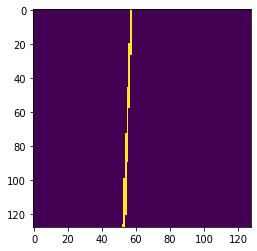

In [26]:
allmasks = []
gantry_angles = []
for beam in dsp.BeamSequence:
    cp1 = beam.ControlPointSequence[0]
    print(f"Generating beamlets for beam {beam.BeamNumber}, with a gantry angle of {cp1.GantryAngle}.")
    gantry_angles.append(cp1.GantryAngle)
    mask_beam = calculate_beamlets(isocenter, cp1.GantryAngle, beam_angle, total_beamlets, ds);    
    allmasks.append(mask_beam) 
    
plt.imshow(allmasks[3][:,:,4])


In [28]:
testLocations = np.where(allmasks[1][:,:,3])

In [29]:
len(testLocations[0])

190

In [30]:
def calculatedose(source, curmask, xvals, yvals, isocenter, gantry_angle, external):
    
    source_x = source[0]
    source_y = source[1]

    
    
    curdose = np.zeros(xv.shape)
    
    beamlocs = np.where(curmask)
    
    
    tempdose = np.zeros(beamlocs[0].shape)
    for k in range(len(beamlocs[0])):
        curx = xvals[beamlocs[1][k]]
        cury = yvals[beamlocs[0][k]]
        depth = get_depth([curx,cury], isocenter, gantry_angle, external)
        if depth < 40:
            #print([curx,cury,isocenter,gantry_angle,depth])
            tempdose[k] = TMR(depth)
            #print([curx,cury,isocenter,gantry_angle,depth, TMR(depth)])
            #tempdose[k] = depth
    
    curdose[beamlocs] = tempdose
    
    return curdose

In [31]:
# Compute the source location
iso_x = isocenter[0]
iso_y = isocenter[1]

# In image coordinates
# 0 degrees is 100 cm more negative in the y direction
# 180 degrees is 100 cm more positive in the y direction
# 90 degrees is 100 cm more positive in the x direction
# 270 degrees is 100 cm more negative in the x direction
gantry_radians = np.pi*(gantry_angle/180)
source_x = iso_x + 1000*np.sin(gantry_radians)
source_y = iso_y - 1000*np.cos(gantry_radians)

#
xvals = iso_x + (np.arange(ds.Rows) - ds.Rows/2)*ds.PixelSpacing[0]
yvals = iso_y + (np.arange(ds.Columns) - ds.Columns/2)*ds.PixelSpacing[1]
xvals = xvals[::4]
yvals = yvals[::4]

xv,yv = np.meshgrid(xvals,yvals)

# Run forward problem given some fluence values
num_gantry_angles = len(gantry_angles)
fluence = np.random.rand(num_gantry_angles,total_beamlets)
dosemap = np.zeros([ds.Rows,ds.Columns])
dosemap = np.zeros([128,128])

alldms = np.zeros([128, 128,num_gantry_angles, total_beamlets ])
for kgan in range(num_gantry_angles):
    for kbeam in range(total_beamlets):
        curmap = calculatedose([source_x,source_y], allmasks[kgan][:,:,kbeam], xvals, yvals, isocenter, gantry_angles[kgan], exter)
        dosemap = dosemap + fluence[kgan,kbeam]*curmap
        alldms[:,:,kgan,kbeam] = curmap


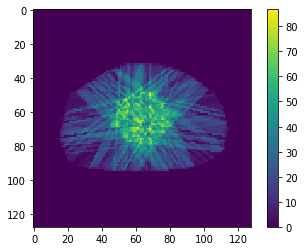

In [32]:
fluence = 20*np.random.rand(num_gantry_angles,total_beamlets)
dosemap = np.zeros([128,128])
for kgan in range(num_gantry_angles):
    for kbeam in range(total_beamlets):
        dosemap = dosemap + fluence[kgan,kbeam]*alldms[:,:,kgan,kbeam]
        

plt.imshow(dosemap,vmin=0)
plt.colorbar();


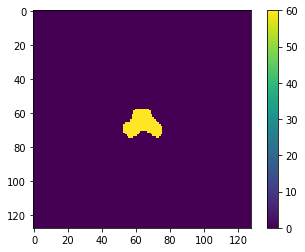

In [33]:
# Let's set up our optimization problem
# Create the desired dose distribution
ptv = roi_dict["PTV_p"][0][:,0:2]
from matplotlib import path
p = path.Path(ptv)  # Path describing our target volume
xypoints = np.concatenate((xv.reshape(128*128,1), yv.reshape(128*128,1)), axis=1);
mask_ptv = p.contains_points(xypoints).reshape((128,128));

## Let's create some weights describing which regions we care about the most
Femur_Head_R = roi_dict["Femur_Head_R"][0][:,0:2]
p = path.Path(Femur_Head_R)  # Path describing a region we wish to protect
mask_femur_r = p.contains_points(xypoints).reshape((128,128));
Femur_Head_L = roi_dict["Femur_Head_L"][0][:,0:2]
p = path.Path(Femur_Head_L)  # Path describing a region we wish to protect
mask_femur_l = p.contains_points(xypoints).reshape((128,128));
Rectum = roi_dict["Rectum"][0][:,0:2]
p = path.Path(Rectum)  # Path describing a region we wish to protect
mask_rectum = p.contains_points(xypoints).reshape((128,128));
weights = np.ones((128,128))
weights[mask_femur_l] = 5
weights[mask_femur_r] = 5
weights[mask_rectum] = 5
weights[mask_ptv] = 10




b = 60*mask_ptv # Target dose

plt.imshow(b)
plt.colorbar();